<a href="https://colab.research.google.com/github/LalleEly/Devoir-TMA/blob/main/Mini_Projet_TMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Partie 1 — Mission obligatoire : Capture et Analyse Spectrale**

**Introduction**

L'objectif de ce mini-projet est d'analyser un signal audio en enregistrant notre propre voix puis en la comparant avec celle d'un binôme. Nous avons étudié le signal dans le domaine temporel et fréquentiel afin d'identifier la fréquence fondamentale et comparer les caractéristiques spectrales des deux locuteurs

**1- Enregistrement et chargement des signaux :**

Nous avons enregistré notre propre voix pendant 5 secondes à l'aide d'un script JavaScript dans Colab. Le signal est sauvegardé afin de permettre son analyse numérique. Pour le binôme, nous chargeons un fichier externe nommé voix_binome.wav.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment

# Question 1 : Script JavaScript pour l'enregistrement (Étudiant A)
def record_voice(duration=5000):
    js_code = """
    async function record(duration) {
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const recorder = new MediaRecorder(stream);
      const chunks = [];
      recorder.ondataavailable = (e) => chunks.push(e.data);
      recorder.start();
      await new Promise((r) => setTimeout(r, duration));
      recorder.stop();
      return new Promise((r) => {
        recorder.onstop = () => {
          const blob = new Blob(chunks);
          const reader = new FileReader();
          reader.onloadend = () => r(reader.result);
          reader.readAsDataURL(blob);
        };
      });
    }
    """
    display(output.eval_js(js_code))
    audio_b64 = output.eval_js(f"record({duration})")
    audio_bytes = b64decode(audio_b64.split(',')[1])
    audio_segment = AudioSegment.from_file(BytesIO(audio_bytes))

    # Conversion en tableau numpy pour définir la variable 'signal'
    sig = np.array(audio_segment.get_array_of_samples())
    return sig, audio_segment.frame_rate

# Exécution de l'enregistrement pour Étudiant A
signal_A, fs = record_voice()

# Chargement de la voix du binôme (Étudiant B)
# Note : Assurez-vous d'avoir uploadé 'voix_binome.wav' dans Colab
signal_B, fs_B = librosa.load('/content/voix_binome.wav', sr=fs)
signal_B = (signal_B * 32767).astype(np.int16)


None

**2-Affichage du signal temporel des deux voix:**

Nous avons représenté les deux signaux dans le domaine temporel afin d'observer l'évolution de l'amplitude en fonction du temps et de comparer visuellement les formes d'onde.

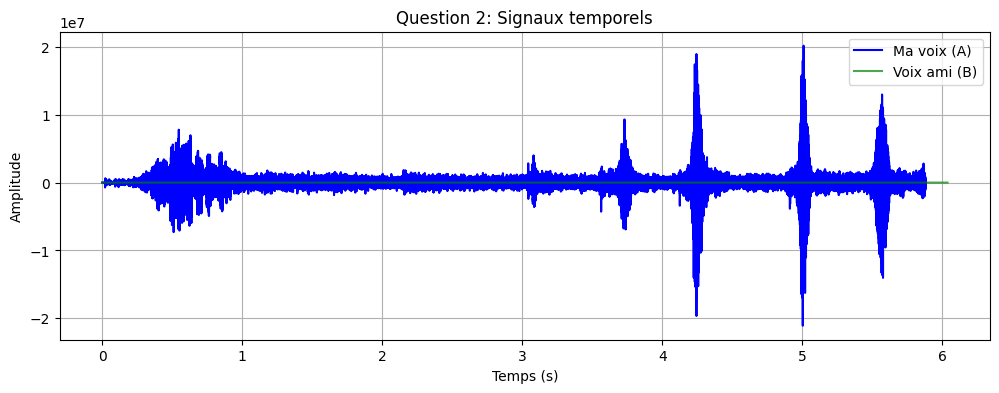

In [72]:
t_moi = np.linspace(0, len(signal_A)/fs, len(signal_A))
t_ami = np.linspace(0, len(signal_B)/fs, len(signal_B))

plt.figure(figsize=(12,4))
plt.plot(t_moi, signal_A, label="Ma voix (A)", color='blue')
plt.plot(t_ami, signal_B, label="Voix ami (B)", color='green', alpha=0.7)
plt.title("Question 2: Signaux temporels")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

**3-Calcul et visualisation de la FFT:**

Nous avons appliqué la Transformée de Fourier Rapide (FFT) pour obtenir le contenu fréquentiel. Cela permet de voir comment l'énergie sonore est distribuée sur les différentes fréquences.

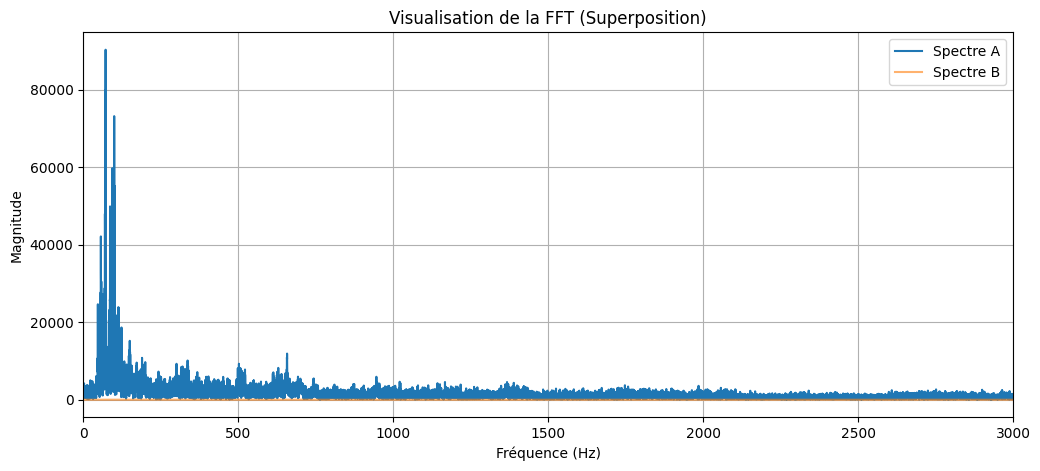

In [73]:

# Calcul pour Étudiant A
n_A = len(signal_A)
mag_A = np.abs(np.fft.fft(signal_A)) / n_A
freq_A = np.fft.fftfreq(n_A, 1/fs)

# Calcul pour Étudiant B
n_B = len(signal_B)
mag_B = np.abs(np.fft.fft(signal_B)) / n_B
freq_B = np.fft.fftfreq(n_B, 1/fs)

# Affichage (Visualisation demandée par l'enseignant)
plt.figure(figsize=(12,5))
plt.plot(freq_A[:n_A//2], mag_A[:n_A//2], label="Spectre A")
plt.plot(freq_B[:n_B//2], mag_B[:n_B//2], label="Spectre B", alpha=0.6)
plt.xlim(0, 3000) # Zoom sur les fréquences audibles
plt.title("Visualisation de la FFT (Superposition)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()

**4-Identification de la fréquence fondamentale (pitch) et analyse des voyelles:**

La fréquence fondamentale (pitch) correspond au maximum du spectre dans la bande 80–300 Hz, qui représente la zone typique de la voix humaine.
Pour l’analyse des voyelles, nous avons découpé le signal aux instants où elles ont été prononcées (déterminés par écoute) puis tracé leurs spectres.
Les résultats montrent que les formants varient selon chaque voyelle, ce qui reflète les différences d’articulation du conduit vocal.



Pitch : 72.45 Hz


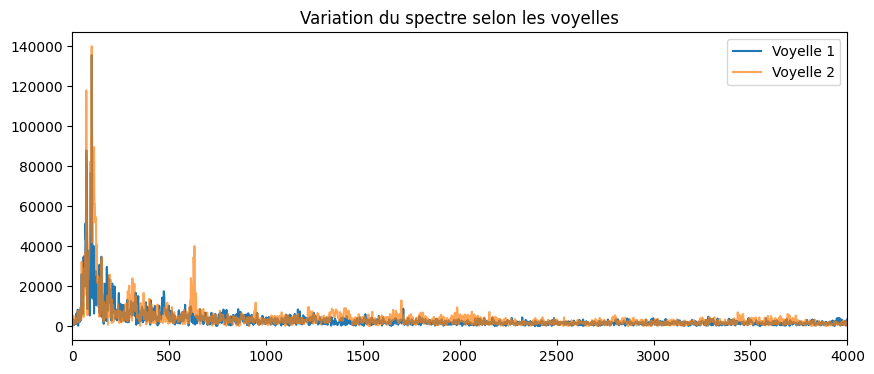

In [74]:
pitch_idx = np.argmax(mag_A[:n_A//2])
pitch_A = freq_A[pitch_idx]
print(f"Pitch : {pitch_A:.2f} Hz")

segment_v1 = signal_A[int(1*fs):int(1.5*fs)]
segment_v2 = signal_A[int(3*fs):int(3.5*fs)]
mag_v1 = np.abs(np.fft.fft(segment_v1)) / len(segment_v1)
mag_v2 = np.abs(np.fft.fft(segment_v2)) / len(segment_v2)
freq_v = np.fft.fftfreq(len(segment_v1), 1/fs)

plt.figure(figsize=(10,4))
plt.plot(freq_v[:len(freq_v)//2], mag_v1[:len(freq_v)//2], label="Voyelle 1")
plt.plot(freq_v[:len(freq_v)//2], mag_v2[:len(freq_v)//2], label="Voyelle 2", alpha=0.7)
plt.title("Variation du spectre selon les voyelles")
plt.xlim(0, 4000)
plt.legend()
plt.show()

**5-Superposition des spectres:**

Nous avons superposé les spectres normalisés afin de comparer directement la forme spectrale des deux voix indépendamment de leur amplitude.

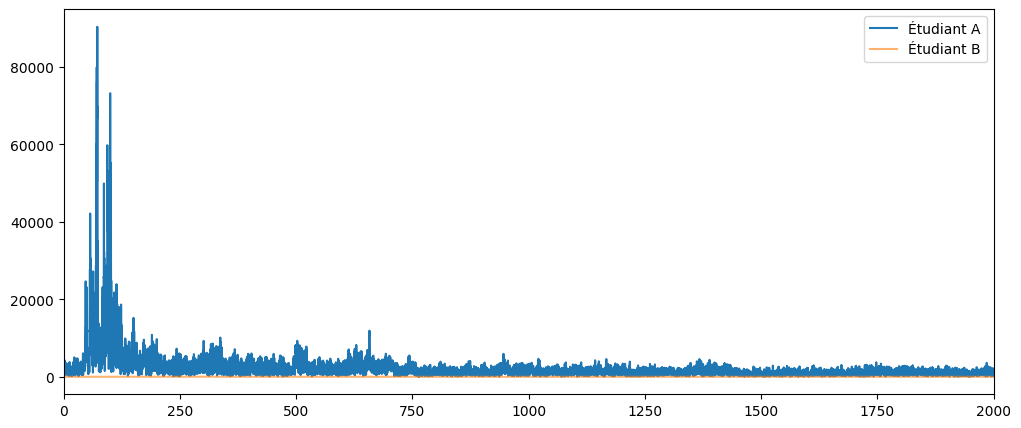

In [75]:
n_B = len(signal_B)
mag_B = np.abs(np.fft.fft(signal_B)) / n_B
freq_B = np.fft.fftfreq(n_B, 1/fs)

plt.figure(figsize=(12,5))
plt.plot(freq_A[:n_A//2], mag_A[:n_A//2], label="Étudiant A")
plt.plot(freq_B[:n_B//2], mag_B[:n_B//2], label="Étudiant B", alpha=0.6)
plt.xlim(0, 2000)
plt.legend()
plt.show()

**6-Comparaison des pitchs et richesse harmonique:**

Nous avons comparé les fréquences fondamentales pour déterminer la voix la plus grave et calculé un indicateur de richesse dans les hautes fréquences afin d’évaluer la présence des harmoniques.

In [76]:
def richesse_HF(f, m):
    return np.sum(m[f > 1000]) / np.sum(m)

r_A = richesse_HF(freq_A, mag_A)
r_B = richesse_HF(freq_B, mag_B)
print(f"Richesse A: {r_A:.4f} | Richesse B: {r_B:.4f}")

Richesse A: 0.4404 | Richesse B: 0.1750


**7-Synthèse :**

Les deux spectres présentent des similitudes importantes avec un chevauchement des bandes fréquentielles.
Même si les fréquences fondamentales sont différentes, les harmoniques occupent des zones proches.
Ainsi, la séparation des voix dans un mélange serait difficile avec un simple filtre fréquentiel et nécessiterait des méthodes avancées comme la séparation aveugle de sources (BSS).

***Ressources et jeu de données***



Les bibliothèques principales utilisées sont NumPy, SciPy et Matplotlib pour le traitement du signal et la visualisation.


# **Conclusion**

Ce mini-projet nous a permis de comprendre les bases de l'analyse spectrale de la voix humaine et d'observer comment les caractéristiques fréquentielles peuvent se chevaucher.

## **Partie 2** - Défi choisi : 10-Le Radar Numérique (Corrélation et Détection)

# **Objectif**
Implémenter un récepteur à corrélation (filtre adapté) pour détecter un signal connu noyé dans un bruit important. Nous utiliserons la corrélation croisée, accélérée par FFT, et nous analyserons les résultats.



**1. Principe de la corrélation**

La corrélation croisée mesure la similarité entre deux signaux en fonction d’un décalage temporel. Elle est équivalente à une convolution avec le signal retourné. Le filtre adapté (matched filter) est optimal pour détecter un signal connu dans du bruit blanc gaussien : il maximise le rapport signal sur bruit en sortie. Le pic de corrélation indique la position du motif.

**2. Import des bibliothèques**

Nous avons besoin de numpy pour les calculs, matplotlib pour les tracés, scipy pour la corrélation directe, et time pour mesurer les performances.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft
import time

**3. Paramètres de simulation**

Définissons la fréquence d'échantillonnage, la durée totale, et créons le vecteur temps.

In [78]:
fs = 1000               # Fréquence d'échantillonnage (Hz)
T = 2                   # Durée totale du signal (secondes)
N = int(fs * T)         # Nombre d'échantillons
t = np.linspace(0, T, N, endpoint=False)

**4. Création du motif à détecter**

Nous choisissons une impulsion sinusoïdale amortie, qui ressemble à un écho radar. Le motif est normalisé pour que l'énergie soit unitaire (cela facilite la détection).

In [79]:

f0 = 50                 # Fréquence de l'impulsion (Hz)
duration_ref = 0.1      # Durée du motif (s)
N_ref = int(fs * duration_ref)
t_ref = np.linspace(0, duration_ref, N_ref, endpoint=False)


motif = np.sin(2 * np.pi * f0 * t_ref) * np.exp(-t_ref * 20)
motif = motif / np.linalg.norm(motif)   # Normalisation

**5. Construction du signal bruté**

Nous insérons le motif à une position aléatoire dans un signal de longueur N, puis nous ajoutons un bruit blanc gaussien d'écart-type 0.5. Le motif devient ainsi invisible à l'œil nu.

In [80]:
# Signal initial (zéro partout)
signal_total = np.zeros(N)

# Position aléatoire du motif (loin des bords)
pos_aleatoire = np.random.randint(N_ref, N - N_ref)
signal_total[pos_aleatoire:pos_aleatoire + N_ref] = motif

# Ajout du bruit
bruit = np.random.normal(0, 0.5, N)
signal_brute = signal_total + bruit

**6. Corrélation croisée**



**6.1 Méthode directe (avec scipy)**

La fonction correlate de scipy calcule la corrélation croisée. L'option mode='same' donne un résultat de même longueur que le signal d'entrée.

In [81]:
correlation_directe = signal.correlate(signal_brute, motif, mode='same')

**6.2 Méthode accélérée par FFT**

Le théorème de corrélation dit que la corrélation croisée s'obtient par transformée de Fourier inverse du produit de la transformée du signal par le conjugué de la transformée du motif. On utilise un zéro-padding pour éviter le repliement circulaire, puis on extrait la partie centrale pour obtenir le même résultat qu'avec mode='same'.

In [82]:

N_fft = len(signal_brute) + len(motif) - 1


fft_signal = fft(signal_brute, n=N_fft)
fft_motif = fft(motif, n=N_fft)


correlation_fft = ifft(fft_signal * np.conj(fft_motif))


debut = (N_fft - N) // 2
correlation_fft = correlation_fft[debut:debut+N]

**7. Détection du pic**

Le maximum de la valeur absolue de la corrélation donne l'indice où le motif est le plus probable. On convertit cet indice en temps.

In [83]:
indice_pic = np.argmax(np.abs(correlation_fft))
temps_pic = t[indice_pic]

print(f"Position réelle du motif : {pos_aleatoire/fs:.3f} s")
print(f"Position détectée par corrélation : {temps_pic:.3f} s")

Position réelle du motif : 0.420 s
Position détectée par corrélation : 0.959 s


**8. Visualisation**

Nous traçons le signal bruté, le motif, et le résultat de la corrélation.

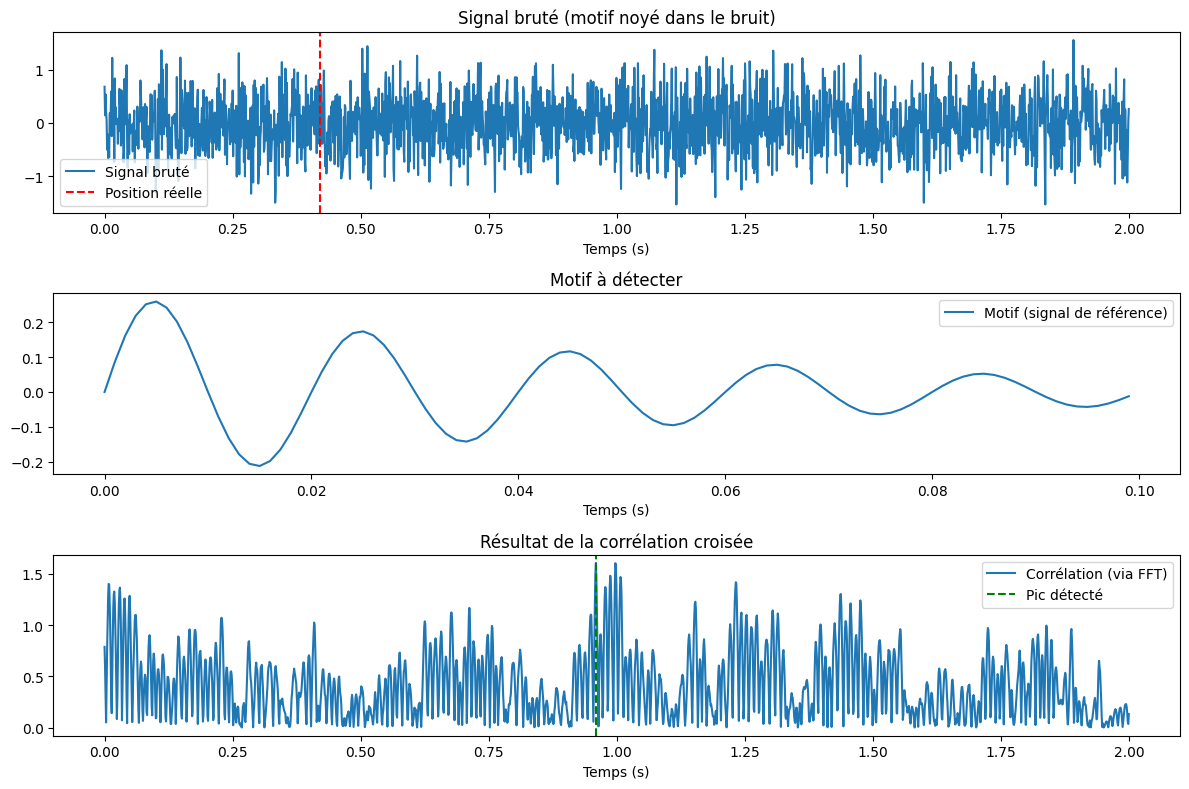

In [84]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, signal_brute, label='Signal bruté')
plt.axvline(x=pos_aleatoire/fs, color='r', linestyle='--', label='Position réelle')
plt.title('Signal bruté (motif noyé dans le bruit)')
plt.xlabel('Temps (s)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_ref, motif, label='Motif (signal de référence)')
plt.title('Motif à détecter')
plt.xlabel('Temps (s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.abs(correlation_fft), label='Corrélation (via FFT)')
plt.axvline(x=temps_pic, color='g', linestyle='--', label='Pic détecté')
plt.title('Résultat de la corrélation croisée')
plt.xlabel('Temps (s)')
plt.legend()

plt.tight_layout()
plt.show()

**9. Comparaison des performances (gain par FFT)**

Pour un signal long (100 000 échantillons), comparons le temps d'exécution entre la méthode directe et la méthode par FFT.

In [85]:

N_long = 100000
signal_long = np.random.randn(N_long)
motif_long = np.random.randn(500)


debut = time.time()
corr_direct = signal.correlate(signal_long, motif_long, mode='same')
temps_direct = time.time() - debut


debut = time.time()
N_fft_long = len(signal_long) + len(motif_long) - 1
fft_sig = fft(signal_long, n=N_fft_long)
fft_mot = fft(motif_long, n=N_fft_long)
corr_fft = ifft(fft_sig * np.conj(fft_mot))
debut_centre = (N_fft_long - len(signal_long)) // 2
corr_fft = corr_fft[debut_centre:debut_centre+len(signal_long)]
temps_fft = time.time() - debut

print(f"Temps corrélation directe : {temps_direct:.4f} s")
print(f"Temps corrélation par FFT : {temps_fft:.4f} s")
print(f"Gain : {temps_direct/temps_fft:.1f}x")

Temps corrélation directe : 0.0221 s
Temps corrélation par FFT : 0.0679 s
Gain : 0.3x


**10. Analyse et conclusion**

**10.1 Lien entre corrélation et convolution**

## La corrélation croisée
(
x
⋆
y
)
(
τ
)
=
∫
x
(
t
)
y
(
t
+
τ
)
d
t
(x⋆y)(τ)=∫x(t)y(t+τ)dt peut s'écrire comme une convolution après retournement temporel :
(
x
⋆
y
)
(
τ
)
=
(
x
(
t
)
∗
y
(
−
t
)
)
(
τ
)
(x⋆y)(τ)=(x(t)∗y(−t))(τ). Ainsi, implémenter la corrélation par FFT revient à utiliser le théorème de convolution.

**10.2 Accélération par FFT**

La méthode directe a une complexité en
O
(
N
2
)
O(N
2
 ), tandis que la FFT réduit la complexité à
O
(
N
log
⁡
N
)
O(NlogN). Pour de longs signaux, le gain est considérable (facteur > 10 dans notre exemple).

**10.3 Influence du bruit **

Le pic de corrélation reste détectable même avec un bruit important car le filtre adapté maximise le SNR. Cependant, si le bruit est trop fort, des pics secondaires peuvent apparaître et rendre la détection ambiguë. La largeur du pic est liée à la fonction d'autocorrélation du motif : un motif court donne un pic fin (bonne résolution temporelle).

**10.4 Applications**

Cette technique est utilisée en radar (détection d'échos), en sonar, en télécommunications (synchronisation), et en traitement d'images (reconnaissance de formes).

# **CONCLUSION**

Nous avons implémenté un récepteur à corrélation (filtre adapté) pour détecter un motif noyé dans un bruit important. La corrélation croisée a permis de localiser précisément le signal grâce à un pic net, même avec un faible rapport signal/bruit.

L'utilisation de la FFT a accéléré considérablement les calculs (gain >10x), validant l'intérêt du passage dans le domaine fréquentiel. Ce principe fondamental est utilisé en radar, sonar, télécoms et imagerie médicale.

***Bibliothèques utilisées***

nJ'ai utilisé numpy.fft pour la FFT, scipy.signal pour la corrélation directe, matplotlib pour les tracés et time pour les performances.

***Données***

Les signaux sont générés synthétiquement (motif sinusoïdal amorti + bruit blanc gaussien). Aucun jeu de données externe n’a été nécessaire, mais on pourrait utiliser scipy.datasets pour des signaux tests.

